In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('./code')
import get_mta_data as gmd
import process_mta_data as pmd

#### Challenge 1   
  
- Open up a new IPython notebook
- Download a few MTA turnstile data files
- Load the files into a pandas DataFrame (hint: `pd.read_csv()` to load files and `pd.concat()` to combine DataFrames)

In [2]:
#get list of filenames based on month,year
years = [2019]
months = [4,5]
files = gmd.generate_filenames(years,months)

In [3]:
#get data from files into dataframe named mta
mta_df_list = []
for file in files:
    mta_df_list += [pd.read_csv('../data/raw/'+file)]
mta = pd.concat(mta_df_list, ignore_index=True)

In [4]:
#rename row 10 to 'EXITS'
mta.rename(columns={mta.columns[10]:'EXITS'},inplace=True)

#### Challenge 2

- Let's turn this into a time series.

- Our pandas dataframe has columns called `Date` and `Time` (what datatype did pandas assign to these columns on import?), however in python and pandas we can convert date and time information to _datetime_ objects, which allow us to do time-based operations

- Using either [pd.to_datetime](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) in pandas or the [python datetime library](https://docs.python.org/2/library/datetime.html), combine the `Date` and `Time` columns into a single new column of the datetime datatype

In [5]:
#go to datetime
mta['DATETIME'] = mta.DATE+' '+mta.TIME
mta['DATETIME'] = pd.to_datetime(mta['DATETIME'],format='%m/%d/%Y %H:%M:%S')
mta['DATE'] = pd.to_datetime(mta['DATE'])
mta.sort_values(by=['C/A', 'UNIT', 'SCP', 'STATION','DATETIME'],inplace=True)


#### Challenge 3

- Each row is a turnstile, identified by a combination of  the `C/A`, `UNIT`, `SCP`, and `STATION` columns, with information on entries and exits at that turnstile every n hours. (What is n?) We want total daily entries. 
- Group the data so that it represents **daily entries** for each turnstile (hint: `pd.groupby` or `DataFrame.groupby`)

In [6]:
# look at time difference
mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-03-30,00:00:00,REGULAR,6999064,2373568,2019-03-30 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-03-30,04:00:00,REGULAR,6999084,2373576,2019-03-30 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-03-30,08:00:00,REGULAR,6999107,2373622,2019-03-30 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-03-30,12:00:00,REGULAR,6999214,2373710,2019-03-30 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-03-30,16:00:00,REGULAR,6999451,2373781,2019-03-30 16:00:00


n is 4

In [7]:
# check for duplicate entries
(mta.groupby(['C/A', 'UNIT', 'SCP', 'STATION','DATETIME'])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False))

,C/A,UNIT,SCP,STATION,DATETIME,ENTRIES
325159,JFK03,R536,00-03-03,JFK JAMAICA CT1,2019-04-07 01:00:00,2
1338199,R283,R221,00-00-03,167 ST,2019-04-16 04:00:00,2
1338196,R283,R221,00-00-03,167 ST,2019-04-15 16:00:00,2
1338195,R283,R221,00-00-03,167 ST,2019-04-15 12:00:00,2
322988,JFK03,R536,00-00-03,JFK JAMAICA CT1,2019-04-07 01:00:00,2
...,...,...,...,...,...,...
545688,N141,R356,00-00-02,OZONE PK LEFFRT,2019-05-01 16:00:00,1
545687,N141,R356,00-00-02,OZONE PK LEFFRT,2019-05-01 12:00:00,1
545686,N141,R356,00-00-02,OZONE PK LEFFRT,2019-05-01 08:00:00,1
545685,N141,R356,00-00-02,OZONE PK LEFFRT,2019-05-01 04:00:00,1


In [8]:
# look at a duplicate
(mta[(mta['C/A']=='JFK03') & 
    (mta['UNIT']=='R536') & 
    (mta['SCP']=='00-03-02') & 
    (mta['STATION']=='JFK JAMAICA CT1') &
    (mta['DATETIME'] >= '2019-04-07 00:00:00') &
    (mta['DATETIME'] <= '2019-04-07 20:00:00')]
    )

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
239476,JFK03,R536,00-03-02,JFK JAMAICA CT1,E,IND,2019-04-07,01:00:00,REGULAR,827,122,2019-04-07 01:00:00
239477,JFK03,R536,00-03-02,JFK JAMAICA CT1,E,IND,2019-04-07,01:00:00,RECOVR AUD,780,120,2019-04-07 01:00:00
239478,JFK03,R536,00-03-02,JFK JAMAICA CT1,E,IND,2019-04-07,05:00:00,REGULAR,880,151,2019-04-07 05:00:00
239479,JFK03,R536,00-03-02,JFK JAMAICA CT1,E,IND,2019-04-07,09:00:00,REGULAR,1008,196,2019-04-07 09:00:00
239480,JFK03,R536,00-03-02,JFK JAMAICA CT1,E,IND,2019-04-07,13:00:00,REGULAR,1188,248,2019-04-07 13:00:00
239481,JFK03,R536,00-03-02,JFK JAMAICA CT1,E,IND,2019-04-07,17:00:00,REGULAR,1546,349,2019-04-07 17:00:00


In [9]:
# add DESC to the sort to drop the RECOVR AUDs
mta.sort_values(by=['C/A', 'UNIT', 'SCP', 'STATION','DATETIME','DESC'],inplace=True)
mta.drop_duplicates(subset=['C/A', 'UNIT', 'SCP', 'STATION','DATETIME'],keep='last',inplace=True)

In [10]:
# get to daily rows
mta_daily = mta.groupby(["C/A", "UNIT", "SCP", "STATION","DATE"]).ENTRIES.first().reset_index()

# get to daily counts by subtracting pr
mask = mta_daily.duplicated(['C/A', 'UNIT', 'SCP', 'STATION'])
mta_daily['INS'] = np.where(mask, mta_daily['ENTRIES'] - mta_daily['ENTRIES'].shift(1), np.nan)
mta_daily['INS'].value_counts().sort_index()

-2.071638e+09    1
-1.835263e+09    1
-1.437241e+09    1
-8.392517e+08    1
-3.676512e+08    1
                ..
 1.126553e+09    1
 1.174407e+09    1
 1.431672e+09    1
 2.011374e+09    1
 2.055526e+09    1
Name: INS, Length: 7922, dtype: int64

In [11]:
# How big of a problem are the negative/huge numbers?
mta_daily[(mta_daily['INS']<0) | (mta_daily['INS'] >200000)].shape[0] / mta.shape[0]

0.001629780761501011

In [12]:
# Drop the negative/huge numbers
mta_daily = mta_daily[(mta_daily['INS'] >= 0) & (mta_daily['INS'] < 200000)]
mta_daily

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,INS
1,A002,R051,02-00-00,59 ST,2019-03-31,6999957,893.0
2,A002,R051,02-00-00,59 ST,2019-04-01,7000528,571.0
3,A002,R051,02-00-00,59 ST,2019-04-02,7002087,1559.0
4,A002,R051,02-00-00,59 ST,2019-04-03,7003680,1593.0
5,A002,R051,02-00-00,59 ST,2019-04-04,7005332,1652.0
...,...,...,...,...,...,...,...
270493,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-05-20,5554,0.0
270494,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-05-21,5554,0.0
270495,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-05-22,5554,0.0
270496,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-05-23,5554,0.0


#### Challenge 4

We will plot the daily time series for a single turnstile.

In ipython notebook, add this to the beginning of your next cell:
```
    %matplotlib inline
```
This will make your matplotlib graphs integrate nicely with the
notebook. 

To plot the time series, import matplotlib with
```
    import matplotlib.pyplot as plt
```
- Select one turnstile (combination of [`C/A`, `UNIT`, `SCP`, `STATION`])
- Filter your pandas DataFrame so it only represents a single turnstile (make sure that turnstile has entries for multiple days).
- Using matplotlib, create a plot with the days on the X axis and the daily entries for that turnstile on the Y axis

You can use the following as a starting point:
```
    plt.figure(figsize=(10,3))
    plt.plot(<days>,<entries>)

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0, 0.5, 'Daily Entries')

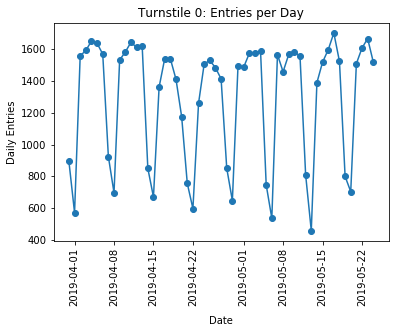

In [21]:
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# pick turnstile 0
ts0 = mta_daily[(mta_daily['C/A']=='A002') & 
          (mta_daily['UNIT']=='R051') & 
          (mta_daily['SCP']=='02-00-00') & 
          (mta_daily['STATION']=='59 ST')]

# plot date vs INS
plt.title('Turnstile 0: Entries per Day')
plt.plot_date(ts0['DATE'],ts0['INS'],
              linestyle='solid',xdate=True,ydate=False)
plt.xticks(rotation='vertical')                             # write the dates vert., overlapped when horiz.
plt.xlabel('Date', labelpad=10)                             # move the label down so dates aren't crowded
plt.ylabel('Daily Entries')


In [20]:
ts0.dtypes

C/A                object
UNIT               object
SCP                object
STATION            object
DATE       datetime64[ns]
ENTRIES             int64
INS               float64
dtype: object

#### Challenge 5

- So far we've been operating on a single turnstile level, let's
  combine turnstiles in the same ControlArea/Unit/Station combo. There
  are some ControlArea/Unit/Station groups that have a single
  turnstile, but most have multiple turnstiles-- same value for the
  C/A, UNIT and STATION columns, different values for the SCP column.

We want to combine the numbers together -- for each
ControlArea/UNIT/STATION combo, for each day, sum the counts from each
turnstile belonging to that combo. (hint: `pd.groupby`)

In [15]:
# group turnstiles in each station area (same C/A, UNIT, STATION) and date,
# add up turnstiles entries, sort by station area and date
mta_ts_sum = (
    mta_daily
    .groupby(['C/A', 'UNIT', 'STATION','DATE'])[['INS']]
    .sum()
    .reindex()
    .sort_values(['C/A','UNIT','STATION','DATE'])
)
mta_ts_sum

INS
C/A   UNIT STATION       DATE               
A002  R051 59 ST         2019-03-31   8661.0
                         2019-04-01   6057.0
                         2019-04-02  12769.0
                         2019-04-03  13233.0
                         2019-04-04  13552.0
...                                      ...
TRAM2 R469 RIT-ROOSEVELT 2019-05-20   3944.0
                         2019-05-21   3362.0
                         2019-05-22   3364.0
                         2019-05-23   3370.0
                         2019-05-24   2845.0

[40773 rows x 1 columns]


#### Challenge 6

Similarly, combine everything in each station, and come up with **daily** time
series for each STATION, by adding up all the turnstiles in a station.


In [16]:
# group turnstiles by station, add up turnstile entries
mta_sta_sum = (
    mta_daily
    .groupby(['STATION','DATE'])[['INS']]
    .sum()
    .reindex()
    .sort_values(['STATION','DATE'])
)
mta_sta_sum

INS
STATION   DATE               
1 AV      2019-03-31  15339.0
          2019-04-01  11278.0
          2019-04-02  19763.0
          2019-04-03  20403.0
          2019-04-04  21357.0
...                       ...
ZEREGA AV 2019-05-20    609.0
          2019-05-21   2768.0
          2019-05-22   2869.0
          2019-05-23   2879.0
          2019-05-24   2763.0

[20718 rows x 1 columns]

#### Challenge 7

Plot the daily time series for a station.

Text(0, 0.5, 'Daily Entries')

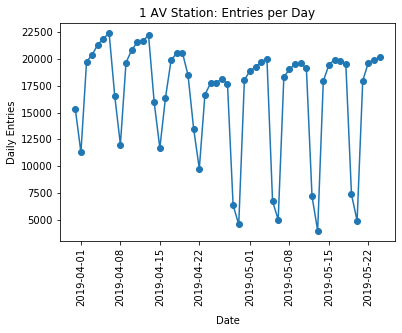

In [17]:
# pick turnstile 0
sta0 = mta_sta_sum.loc['1 AV'].reset_index()

# plot date vs INS
plt.title('1 AV Station: Entries per Day')
plt.plot_date(sta0['DATE'],sta0['INS'],
              linestyle='solid',xdate=True,ydate=False)
plt.xticks(rotation='vertical')                             # write the dates vert., overlapped when horiz.
plt.xlabel('Date', labelpad=10)                             # move the label down so dates aren't crowded
plt.ylabel('Daily Entries')

#### Challenge 8

- Make one list of counts for **one** week for one station. Monday's
count, Tuesday's count, etc. so it's a list of 7 counts.
Make the same list for another week, and another week, and another
week. (hint: [pandas datetime day of week](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.dayofweek.html#pandas.Series.dt.dayofweek) may be useful)

`plt.plot(week_count_list)` for every `week_count_list` you created
this way. You should get a rainbow plot of weekly commute numbers on
top of each other.

In [24]:
#mta_sta_sum.reset_index(level='DATE',inplace=True)
mta_sta_sum['DAY_OF_WEEK'] = mta_sta_sum['DATE'].dt.dayofweek

'''wk = pd.Timedelta(1,unit='W')
sta0 = mta_sta_sum.loc['1 AV']
sta0'''

KeyError: 'DATE'

In [ ]:

wk.days